```
學號：0716026 
姓名：蕭楚澔
```

In [1]:
# Import

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot  import MultipleLocator
import copy
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import prettytable as pt
from tabulate import tabulate

```
1. Data Input
```

In [2]:
# Data Input

# Wheat
with open('seeds_dataset.txt') as datafile:
    datasets = datafile.readlines()
    
# Ionosphere
read_file = pd.read_csv (r'ionosphere.data', header=None)

```
2. Data Preprocessing
```

In [3]:
# Data Preprocessing

# Transform data format and shape so your model can process them.
# Wheat
delete_column = []
for i in range(len(datasets)-1, -1, -1):
    datasets[i] = datasets[i].split('\t')
    if(len(datasets[i]) == 8):
        datasets[i][7] = datasets[i][7].replace('\n', '')
    else:
        delete_column.append(i)

column = ['area', 'perimeter', 'compactness', 'length of kernel', 'width of kernel', 'asymmetry coefficient', 
          'length of kernel groove', 'varieties of wheat']
for num in delete_column:
    del datasets[num]
df1 = pd.DataFrame(datasets)
df1.columns = column

# Ionosphere
df2 = read_file.copy(deep=True)
df2 = df2.rename(columns={34: 'label'})

# Shuffle the data.
df1 = shuffle(df1)
df2 = shuffle(df2)

In [4]:
# function

def distance(list1, list2):
    sum = 0
    for i in range(0, len(list1)-1):
        sum+=(np.square(float(list1[i])-float(list2[i])))
    return np.sqrt(sum)

def shortest(d_list, C):
    K = len(C)
    minimum = distance(d_list, C[0])
    result = 0
    for i in range(0, K):
        dist = distance(d_list, C[i])
        if(dist<minimum):
            minimum = dist
            result = i
    return result

def summarize(ds, j):
    sum = 0
    for i in range(0, len(ds)):
        sum+=float(ds[i:i+1].values[0][j])
    return sum

def check_update(C, C_pre, K):
    res = True
    for i in range(0, K):
        if(C[i] != C_pre[i]):
            res = False
            break
    return res

```
3. K-means Clustering
```

In [5]:
# K-means Clustering

ds = df1.drop(columns = ['varieties of wheat'])
closest = [0 for _ in range(len(ds))]
ds['closest'] = closest
K = 3
C = [ [] for _ in range(K)]
C_pre = [ [] for _ in range(K)]

# Randomly initial k centers C={c1, ..., ck}
for i in range(0, K):
    x = np.random.randint(0, len(ds))
    for j in range(0, len(ds[0:1].values[0])):
        C[i].append(ds[x:x+1].values[0][j])
        
# while stopping criterion has not been met
while(check_update(C, C_pre, K) == False):
    # assignment step
    # find closest center cj to instance pi assign instance pi to set Cj
    for i in range(0, len(ds)):
        d_list = ds[i:i+1].values[0].tolist()
        closest[i] = shortest(d_list, C)
    ds['closest'] = closest
    C_pre = copy.deepcopy(C)
    # update step
    # set ci to be the center of all points in set Ci
    for i in range(0, K):
        cond_ds = ds[ds['closest'] == i]
        for j in range(0, len(ds[x:x+1].values[0])):
            C[i][j] = summarize(cond_ds, j)/len(cond_ds)

# In the end, calculate the labels of the instances in set Ci and assign Ci with the label 
# that has the largest value count.
res = [ [0, 0, 0] for _ in range(K)]
for i in range(0, len(ds)):
    x = ds.values[i][len(ds.values[i])-1]
    x = int(x)
    y = df1.values[i][len(df1.values[i])-1]
    y = int(y)
    y-=1
    res[x][y]+=1
for i in range(0, K):
    res[i] = res[i].index(max(res[i]))

K_means_pred = [0 for _ in range(len(ds))]  
for i in range(0, len(ds)):
    x = ds.values[i][len(ds.values[i])-1]
    x = int(x)
    K_means_pred[i] = res[x]+1

```
4. Support Vector Machine
```

In [6]:
# Support Vector Machine

# Train-Test-Split
ds = df2.copy(deep=True)
X_train, X_test, y_train, y_test = train_test_split(ds.drop('label', axis=1), ds['label'], test_size=0.3)

model = svm.SVC()
L_parameters = [{'kernel': ['linear']}]
P_parameters = [{'kernel': ['poly'], 'degree': [3, 5, 7], 'gamma': [1, 0.1, 0.01], 'coef0': [1, 0.1, 0.01]}]
R_parameters = [{'kernel': ['rbf'], 'gamma': [1, 0.1, 0.01]}]
scores = ["precision", "recall"]

# linear kernel, K=5
L_clf = GridSearchCV(estimator=model, param_grid=L_parameters, cv=5)
L_clf.fit(X_train, y_train)
linear_svm_pred = L_clf.predict(X_test)

# polynomial kernel, K=5
P_clf = GridSearchCV(estimator=model, param_grid=P_parameters, cv=5)
P_clf.fit(X_train, y_train)
poly_svm_pred = P_clf.predict(X_test)

# RBF kernel, K=5
R_clf = GridSearchCV(estimator=model, param_grid=R_parameters, cv=5)
R_clf.fit(X_train, y_train)
rbf_svm_pred = R_clf.predict(X_test)

```
5. Results
```

In [7]:
# Result

df1_test = df1['varieties of wheat'].values
df1_test = list(map(int, df1_test))
df2_test = y_test.copy(deep=True)

test = [df1_test, df2_test, df2_test, df2_test]
pred = [K_means_pred, linear_svm_pred, poly_svm_pred, rbf_svm_pred]
lab = [[1, 2, 3], ['g', 'b'], ['g', 'b'], ['g', 'b']]
name = ["K_means", "svm(linear)", "svm(polynomial)", "svm(RBF)"]

output = pt.PrettyTable()
blank = [" ", " ", " ", " ", " "]
output.field_names = ["Method", "Confusion matrix", "Accuracy", "Recall", "Precision"]
for i in range(0, len(pred)):
    cm = np.around(confusion_matrix(test[i], pred[i]), 5)
    acc = np.around(accuracy_score(test[i], pred[i]), 5)
    rec = np.around(recall_score(test[i], pred[i], labels=lab[i], average=None), 5)
    pre = np.around(precision_score(test[i], pred[i], labels=lab[i], average=None), 5)
    rec_str = ""
    for j in range(0, len(lab[i])):
        add_str = str(lab[i][j])+": "+str(rec[j])+"\n"
        rec_str+=add_str
    pre_str = ""
    for j in range(0, len(lab[i])):
        add_str = str(lab[i][j])+": "+str(pre[j])+"\n"
        pre_str+=add_str
    row = [name[i], cm, acc, rec_str, pre_str]
    output.add_row(row)
    output.add_row(blank)
print(output)

+-----------------+------------------+----------+------------+------------+
|      Method     | Confusion matrix | Accuracy |   Recall   | Precision  |
+-----------------+------------------+----------+------------+------------+
|     K_means     |   [[57  1  8]    | 0.90452  | 1: 0.86364 | 1: 0.85075 |
|                 |    [ 9 59  0]    |          | 2: 0.86765 | 2: 0.98333 |
|                 |    [ 1  0 64]]   |          | 3: 0.98462 | 3: 0.88889 |
|                 |                  |          |            |            |
|                 |                  |          |            |            |
|   svm(linear)   |     [[31 17]     | 0.83019  | g: 0.98276 | g: 0.77027 |
|                 |     [ 1 57]]     |          | b: 0.64583 | b: 0.96875 |
|                 |                  |          |            |            |
|                 |                  |          |            |            |
| svm(polynomial) |     [[35 13]     | 0.87736  |   g: 1.0   | g: 0.8169  |
|           

```
6. Comparison & Conclusion:
先說明我在這次作業是如何實作K means的，主要是參考slide的pseudo code來實作，先隨機指定三點為中心，再將各點指定給離自己最近的中心，接著將之前的中心更新成同一群的中心，不段重複assign和update的工作直到中心不在更動，過程利用一個新建的column - closest來儲存各點所屬的群，最後根據各群當中哪一種label佔最多，來做prediction
    
接著討論SVM的三種kernel，幾次測試的結果都是RBF的結果最好，polynomial的結果次之，linear的結果最差，當然也可能是我取的參數不夠好所造成的，不過因為polynomial和RBF都取了不只一種參數，整體而言還是具有一定參考性的
```

```
7-1. Questions - K-means Clustering:
Choose two features to execute your K-means function and draw a scatter plot with the computed centers 
and the predicted label for each instance.
```

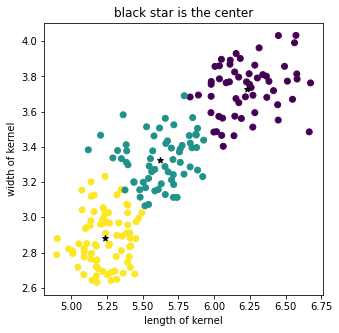

In [8]:
# Questions
# K-means Clustering

ds = df1.loc[:, ['length of kernel', 'width of kernel']]
closest = [0 for _ in range(len(ds))]
ds['closest'] = closest
K = 3
C = [ [] for _ in range(K)]
C_pre = [ [] for _ in range(K)]

# Randomly initial k centers C={c1, ..., ck}
for i in range(0, K):
    x = np.random.randint(0, len(ds))
    for j in range(0, len(ds[0:1].values[0])):
        C[i].append(ds[x:x+1].values[0][j])
        
# while stopping criterion has not been met
while(check_update(C, C_pre, K) == False):
    # assignment step
    # find closest center cj to instance pi assign instance pi to set Cj
    for i in range(0, len(ds)):
        d_list = ds[i:i+1].values[0].tolist()
        closest[i] = shortest(d_list, C)
    ds['closest'] = closest
    C_pre = copy.deepcopy(C)
    # update step
    # set ci to be the center of all points in set Ci
    for i in range(0, K):
        cond_ds = ds[ds['closest'] == i]
        for j in range(0, len(ds[x:x+1].values[0])):
            C[i][j] = summarize(cond_ds, j)/len(cond_ds)

# In the end, calculate the labels of the instances in set Ci and assign Ci with the label 
# that has the largest value count.
res = [ [0, 0, 0] for _ in range(K)]
for i in range(0, len(ds)):
    x = ds.values[i][len(ds.values[i])-1]
    x = int(x)
    y = df1.values[i][len(df1.values[i])-1]
    y = int(y)
    y-=1
    res[x][y]+=1
for i in range(0, K):
    res[i] = res[i].index(max(res[i]))

K_means_pred = [0 for _ in range(len(ds))]  
for i in range(0, len(ds)):
    x = ds.values[i][len(ds.values[i])-1]
    x = int(x)
    K_means_pred[i] = res[x]+1
    
plt.figure(figsize=(5, 5))
x = ds.loc[:, 'length of kernel'].values
y = ds.loc[:, 'width of kernel'].values
x = x.tolist()
y = y.tolist()
x = [ float(n) for n in x]
y = [ float(n) for n in y]
color = ds.loc[:, 'closest'].values
color = color.tolist()
color = [ int(n) for n in color]
plt.scatter(x, y, c = color)

x_centers = [C[0][0], C[1][0], C[2][0]]
y_centers = [C[0][1], C[1][1], C[2][1]]
plt.scatter(x_centers, y_centers, color="black", marker='*')
plt.title("black star is the center")
plt.xlabel("length of kernel")
plt.ylabel("width of kernel")
plt.show()

```

7-2. Questions - Support Vector Machine
Show the average performance of K-fold cross-validation of parameter search in tables for each kernel.
```

In [9]:
# Questions
# Support Vector Machine

df3 = pd.DataFrame(L_clf.cv_results_)
df4 = pd.DataFrame(P_clf.cv_results_)
df5 = pd.DataFrame(R_clf.cv_results_)

print("linear kernel")
df3 = df3.loc[:, ['mean_test_score', 'rank_test_score']]
print(tabulate(df3, headers='keys', tablefmt='psql'))
print("\npolynomial kernel")
df4 = df4.loc[:, ['mean_test_score', 'rank_test_score']]
print(tabulate(df4, headers='keys', tablefmt='psql'))
print("\nRBF kernel")
df5 = df5.loc[:, ['mean_test_score', 'rank_test_score']]
print(tabulate(df5, headers='keys', tablefmt='psql'))

linear kernel
+----+-------------------+-------------------+
|    |   mean_test_score |   rank_test_score |
|----+-------------------+-------------------|
|  0 |          0.877551 |                 1 |
+----+-------------------+-------------------+

polynomial kernel
+----+-------------------+-------------------+
|    |   mean_test_score |   rank_test_score |
|----+-------------------+-------------------|
|  0 |          0.881633 |                 5 |
|  1 |          0.897959 |                 1 |
|  2 |          0.836735 |                14 |
|  3 |          0.865306 |                 8 |
|  4 |          0.885714 |                 3 |
|  5 |          0.857143 |                10 |
|  6 |          0.844898 |                13 |
|  7 |          0.889796 |                 2 |
|  8 |          0.877551 |                 7 |
|  9 |          0.885714 |                 3 |
| 10 |          0.861224 |                 9 |
| 11 |          0.681633 |                22 |
| 12 |          0.857143 | 